In [3]:
# load relevant packages for analysis
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import graph_tool.all as gt
import igraph as ig
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
from multiprocessing import Pool
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
from shapely import wkt
import shapely.wkt
import statsmodels.api as sm
import sys
from xml import etree

# Betweenness Centrality Scores for Clusters
In this notebook we will:
1. Calculate the betweeness centrality scores for the UK Urban Systems we have defined
2. Assign these centrality scores as attributes for each node and edge within the UK network
3. We then end up with a graph where we will be able to view the betweeness centrality scores for all urban systems in the UK.

## 1. Assess Betweeness Centrality for UK Urban Systems using graph_tool
In the following code we run a betweenness centrality analysis on each cluster using igraph, which is faster than NetworkX for such computations.

The following code achieves this through the following steps:
1. Convert each NetworkX subgraph to an igraph graph
2. Compute betweenness centrality for each graph

## 1. Import Libraries and Define Conversion Function

In [5]:
# read in cluster data
G_300m = nx.read_graphml("Data/G_300m.graphml")

In [4]:
# minimum cluster size of 190 intersections
# filter clusters by size
clusters_190 = [c for c in nx.connected_components(G_300m) if len(c) > 190]
print(f"Number of clusters (cities) identified: {len(clusters_190)}")

Number of clusters (cities) identified: 1483


#### Convert NetworkX Graph to Graph_tool format

In [5]:
def nx_to_gt(nx_graph):
    gt_graph = gt.Graph(directed=False)
    nx_to_gt_map = {}
    gt_to_nx_map = {}
    
    for node in nx_graph.nodes:
        v = gt_graph.add_vertex()
        nx_to_gt_map[node] = v
        gt_to_nx_map[v] = node
    
    for edge in nx_graph.edges:
        gt_graph.add_edge(nx_to_gt_map[edge[0]], nx_to_gt_map[edge[1]])
    
    return gt_graph, nx_to_gt_map, gt_to_nx_map

In [6]:
# compute betweenness using graph-tool
def compute_betweenness_centrality(gt_graph):
    vertex_betweenness, edge_betweenness = gt.betweenness(gt_graph)
    return vertex_betweenness, edge_betweenness
    
# process single cluster
def process_cluster(idx, cluster, G_300m):
    print(f"Processing cluster {idx+1}/{len(clusters_190)}")
    
    # cluster nodes subgraph
    cluster_subgraph = G_300m.subgraph(cluster).copy()
    
    # >graph-tool graph
    gt_cluster_subgraph, nx_to_gt_map, gt_to_nx_map = nx_to_gt(cluster_subgraph)
    
    # calc betweenness
    vertex_betweenness, edge_betweenness = compute_betweenness_centrality(gt_cluster_subgraph)
    
    # Prepare betweenness centrality results to return
    node_betweenness = {gt_to_nx_map[v]: vertex_betweenness[v] for v in gt_cluster_subgraph.vertices() if vertex_betweenness[v] > 0}
    edge_betweenness = {(gt_to_nx_map[e.source()], gt_to_nx_map[e.target()]): edge_betweenness[e] for e in gt_cluster_subgraph.edges() if edge_betweenness[e] > 0}
    
    return node_betweenness, edge_betweenness

## 2. Compute & Add Betweeness for Each Cluster

In [7]:
# initialise results list
results = []
for idx, cluster in enumerate(clusters_190):
    result = process_cluster(idx, cluster, G_300m)
    results.append(result)

Processing cluster 1/1483
Processing cluster 2/1483
Processing cluster 3/1483
Processing cluster 4/1483
Processing cluster 5/1483
Processing cluster 6/1483
Processing cluster 7/1483
Processing cluster 8/1483
Processing cluster 9/1483
Processing cluster 10/1483
Processing cluster 11/1483
Processing cluster 12/1483
Processing cluster 13/1483
Processing cluster 14/1483
Processing cluster 15/1483
Processing cluster 16/1483
Processing cluster 17/1483
Processing cluster 18/1483
Processing cluster 19/1483
Processing cluster 20/1483
Processing cluster 21/1483
Processing cluster 22/1483
Processing cluster 23/1483
Processing cluster 24/1483
Processing cluster 25/1483
Processing cluster 26/1483
Processing cluster 27/1483
Processing cluster 28/1483
Processing cluster 29/1483
Processing cluster 30/1483
Processing cluster 31/1483
Processing cluster 32/1483
Processing cluster 33/1483
Processing cluster 34/1483
Processing cluster 35/1483
Processing cluster 36/1483
Processing cluster 37/1483
Processing

In [8]:
for node_betweenness, edge_betweenness in results:
    for node, betweenness in node_betweenness.items():
        if betweenness > 0:  # ensure only non-zero betweenness values are added
            if 'betweenness' not in G_300m.nodes[node]:
                G_300m.nodes[node]['betweenness'] = 0
            G_300m.nodes[node]['betweenness'] += betweenness
    for edge, betweenness in edge_betweenness.items():
        if betweenness > 0:  # ensure only non-zero betweenness values are added
            if G_300m.has_edge(*edge):
                if 'betweenness' not in G_300m.edges[edge]:
                    G_300m.edges[edge]['betweenness'] = 0
                G_300m.edges[edge]['betweenness'] += betweenness

In [9]:
print(f"Number of nodes: {G_300m.number_of_nodes()}")
print(f"Number of edges: {G_300m.number_of_edges()}")

Number of nodes: 3161041
Number of edges: 3448220


In [18]:
G_filtered = G_300m.copy()

# remove nodes w/o betweenness
nodes_to_remove = [node for node in G_filtered.nodes if 'betweenness' not in G_filtered.nodes[node]]
G_filtered.remove_nodes_from(nodes_to_remove)

# remove edges w/o betweenness
edges_to_remove = [edge for edge in G_filtered.edges if 'betweenness' not in G_filtered.edges[edge]]
G_filtered.remove_edges_from(edges_to_remove)

# save
# nx.write_graphml(G_filtered, "Data/G300_betw.graphml")

In [11]:
# verify only 0< values were added back to graph
node_betweenness_df = pd.DataFrame.from_dict(nx.get_node_attributes(G_betw, 'betweenness'), orient='index', columns=['betweenness'])
edge_betweenness_df = pd.DataFrame.from_dict(nx.get_edge_attributes(G_betw, 'betweenness'), orient='index', columns=['betweenness'])

print("Node Betweenness Centrality Statistics after filtering:")
print(node_betweenness_df.describe())

print("\nEdge Betweenness Centrality Statistics after filtering:")
print(edge_betweenness_df.describe())

# check for 0 betweenness values
zero_node_betweenness = node_betweenness_df[node_betweenness_df['betweenness'] == 0]
zero_edge_betweenness = edge_betweenness_df[edge_betweenness_df['betweenness'] == 0]

Node Betweenness Centrality Statistics after filtering:
        betweenness
count  1.405754e+06
mean   5.748386e-02
std    9.498182e-01
min    1.873575e-11
25%    4.066779e-04
50%    3.264655e-03
75%    2.098721e-02
max    4.178300e+01

Edge Betweenness Centrality Statistics after filtering:
        betweenness
count  2.362420e+06
mean   3.479446e-02
std    7.217166e-01
min    5.620666e-11
25%    1.963479e-04
50%    1.455604e-03
75%    8.771771e-03
max    4.178238e+01

Nodes with zero betweenness centrality:
Empty DataFrame
Columns: [betweenness]
Index: []

Edges with zero betweenness centrality:
Empty DataFrame
Columns: [betweenness]
Index: []


In [12]:
print(f"Number of nodes with zero betweenness centrality: {len(zero_node_betweenness)}")
print(f"Number of edges with zero betweenness centrality: {len(zero_edge_betweenness)}")

Number of nodes with zero betweenness centrality: 0
Number of edges with zero betweenness centrality: 0


In [ ]:
# count nodes with betweenness attribute
nodes_with_betweenness = [node for node in G_filtered.nodes if 'betweenness' in G_300m.nodes[node]]
num_nodes_with_betweenness = len(nodes_with_betweenness)
print(f"Number of nodes with betweenness centrality attribute: {num_nodes_with_betweenness}")

# count edges with betweenness attribute
edges_with_betweenness = [edge for edge in G_filtered.edges if 'betweenness' in G_300m.edges[edge]]
num_edges_with_betweenness = len(edges_with_betweenness)
print(f"Number of edges with betweenness centrality attribute: {num_edges_with_betweenness}")

In [16]:
list(G_filtered.edges(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 'D3B5B123-54B7-467E-8C60-BE2383A3624B',
 {'length': 179.0,
  'road_classification': 'Unknown',
  'road_function': 'Restricted Local Access Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)',
  'occupation_probability': 0.00927614779300641})

In [15]:
list(G_filtered.nodes(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 {'pos': '(187422.39, 887423.74)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (187422.39 887423.74)',
  'angle': 126.44988586701946,
  'occupation_probability': 0.7024993659278859})

## 3. Check and Save New Version of *G_300m*

In [ ]:
# save new G_300m (includes 0 betw values)
# nx.write_graphml(G_300m, "Data/G300_betw.graphml")

In [ ]:
print(f"Filtered number of nodes: {G_filtered.number_of_nodes()}")
print(f"Filtered number of edges: {G_filtered.number_of_edges()}")

In [2]:
G_betw = nx.read_graphml('Data/G_betw.graphml')

In [20]:
list(G_betw.nodes(data=True))[0]

('494F06C3-9539-4F7C-A4B9-4BBA6D37BA41',
 {'pos': '(148230.0, 844043.0)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (148230 844043)',
  'angle': 108.15688320081887,
  'occupation_probability': 0.6008715733378825,
  'betweenness': 0.012543476886106368})

In [14]:
list(G_betw.edges(data=True))[0]

('494F06C3-9539-4F7C-A4B9-4BBA6D37BA41',
 'CAF8EC0B-4D68-4258-802F-5C03F74579C4',
 {'length': 32.0,
  'road_classification': 'Unclassified',
  'road_function': 'Local Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (148262 844045, 148246 844044, 148230 844043)',
  'occupation_probability': 0.0016155088852988692,
  'betweenness': 0.0123543927891754})

## Normalise Betweeness values and save as a new graph

In [21]:
# get betweenness values for edges and nodes
edge_betweenness = nx.get_edge_attributes(G_betw, 'betweenness')
node_betweenness = nx.get_node_attributes(G_betw, 'betweenness')

# norm betweenness
if edge_betweenness:
    min_edge_betweenness = min(edge_betweenness.values())
    max_edge_betweenness = max(edge_betweenness.values())
    for edge in edge_betweenness:
        normalized_value = (edge_betweenness[edge] - min_edge_betweenness) / (max_edge_betweenness - min_edge_betweenness)
        G_betw.edges[edge]['normalized_betweenness'] = normalized_value

if node_betweenness:
    min_node_betweenness = min(node_betweenness.values())
    max_node_betweenness = max(node_betweenness.values())
    for node in node_betweenness:
        normalized_value = (node_betweenness[node] - min_node_betweenness) / (max_node_betweenness - min_node_betweenness)
        G_betw.nodes[node]['normalized_betweenness'] = normalized_value

# save graph with normalised betweenness
# nx.write_graphml(G_betw, 'Data/G_betw2.graphml')

Graph saved with normalized betweenness values.


In [4]:
G_betw2 = nx.read_graphml('Data/G_betw2.graphml')

In [27]:
list(G_betw2.edges(data=True))[0]

('494F06C3-9539-4F7C-A4B9-4BBA6D37BA41',
 'CAF8EC0B-4D68-4258-802F-5C03F74579C4',
 {'length': 32.0,
  'road_classification': 'Unclassified',
  'road_function': 'Local Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (148262 844045, 148246 844044, 148230 844043)',
  'occupation_probability': 0.0016155088852988692,
  'betweenness': 0.0123543927891754,
  'normalized_betweenness': 0.000295684264035484})

In [28]:
list(G_betw2.nodes(data=True))[0]

('494F06C3-9539-4F7C-A4B9-4BBA6D37BA41',
 {'pos': '(148230.0, 844043.0)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (148230 844043)',
  'angle': 108.15688320081887,
  'occupation_probability': 0.6008715733378825,
  'betweenness': 0.012543476886106368,
  'normalized_betweenness': 0.0003002052499051736})

In [29]:
print(f"Filtered number of nodes: {G_betw2.number_of_nodes()}")
print(f"Filtered number of edges: {G_betw2.number_of_edges()}")

Filtered number of nodes: 1405754
Filtered number of edges: 1722640


In [31]:
# esnure edge & node normalisation worked
# edge
edge_betweenness = nx.get_edge_attributes(G_betw2, 'normalized_betweenness')
if edge_betweenness:
    max_edge_betweenness = max(edge_betweenness.values())
    min_edge_betweenness = min(edge_betweenness.values())
    print(f"Maximum edge betweenness: {max_edge_betweenness}")
    print(f"Minimum edge betweenness: {min_edge_betweenness}")
else:
    print("No edge betweenness values found.")

# node
node_betweenness = nx.get_node_attributes(G_betw2, 'normalized_betweenness')
if node_betweenness:
    max_node_betweenness = max(node_betweenness.values())
    min_node_betweenness = min(node_betweenness.values())
    print(f"Maximum node betweenness: {max_node_betweenness}")
    print(f"Minimum node betweenness: {min_node_betweenness}")
else:
    print("No node betweenness values found.")

Maximum edge betweenness: 1.0
Minimum edge betweenness: 0.0
Maximum node betweenness: 1.0
Minimum node betweenness: 0.0


## Analysis of Betweeness Centrality of Urban Areas UK

#### Node Betweenness Centrality:

- High Number of Nodes: There are over 3 million nodes in the graph, indicating a highly detailed network representing the UK cities.
- Mean and Median: The mean node betweenness centrality is 0.0256, while the median is 0. This significant difference, along with the fact that the 25th percentile is also 0, suggests that most nodes have very low or zero betweenness centrality.
- Standard Deviation: A high standard deviation (0.634) relative to the mean indicates substantial variability in the betweenness centrality values.
 -Skewness: The maximum betweenness centrality is 41.783, much higher than the mean, indicating a skewed distribution where a few nodes have exceptionally high betweenness centrality.
- Quartiles: The 75th percentile value of 0.00204967 further emphasizes that a significant majority of the nodes have low betweenness centrality, with a few nodes playing critical roles in connecting the network.

#### Edge Betweenness Centrality:

- High Number of Edges: With over 3.4 million edges, the network is very complex and well-connected.
- Mean and Median: The mean edge betweenness centrality is 0.0238, and the median is 0.0002378404. Like the node betweenness, this shows that most edges have low betweenness centrality.
- Standard Deviation: The standard deviation (0.5976) is high relative to the mean, indicating a wide range of betweenness values among the edges.
- Skewness: The maximum edge betweenness centrality is 41.78238, highlighting the presence of a few critical edges with very high centrality.
- Quartiles: The 75th percentile value of 0.003795066 again shows that most edges have low betweenness centrality, with a small number of edges serving as critical connectors in the network.

#### Interpretation:
- Distribution: Both node and edge betweenness centrality values are highly skewed, with most nodes and edges having low betweenness centrality, while a few have very high values. This suggests a few critical nodes and edges are essential for maintaining the connectivity and flow within the urban networks of UK cities.
- Network Structure: The majority of nodes and edges are not central to the network, indicating a potentially decentralized or distributed structure with a few key hubs or connectors.
- Critical Nodes and Edges: The nodes and edges with high betweenness centrality are likely vital for efficient transportation and communication within the urban system. Identifying and potentially reinforcing these critical elements could enhance the resilience and efficiency of the network.

## 3.0 Descriptive Stats on Graph Betweeness Values.

## 3.1 Plot Edge & Node Betweenness Values: NetworkX

Plotting the logarithm of normalised betweenness values is more useful because it compresses the wide range of values, making it easier to visualise and assess the distribution, especially in skewed datasets where most values are very low and only a few are high. This transformation enhances the visibility of the lower end of the range and helps in identifying patterns and outliers that would otherwise be difficult to see on a standard scale.

Text(0, 0.5, 'Frequency (log scale)')

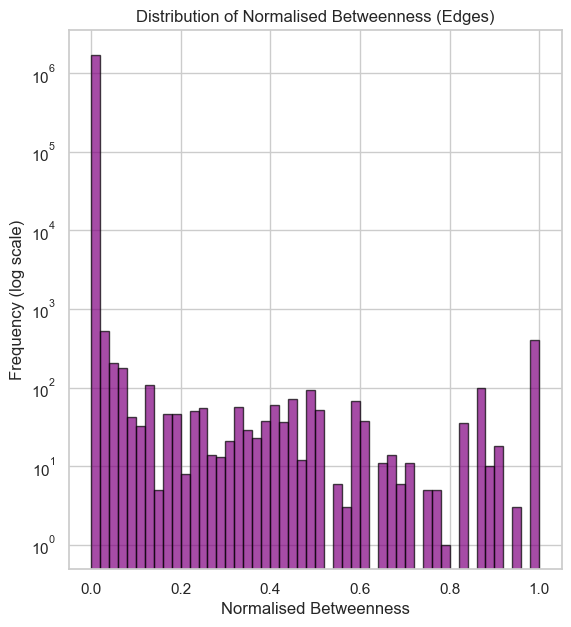

In [46]:
# plot log norm betw (edges)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(edge_normalized_betweenness.values(), bins=50, color='purple', edgecolor='black', alpha=0.7, log=True)
plt.title('Distribution of Normalised Betweenness (Edges)')
plt.xlabel('Normalised Betweenness')
plt.ylabel('Frequency (log scale)')

Text(0, 0.5, 'Frequency (log scale)')

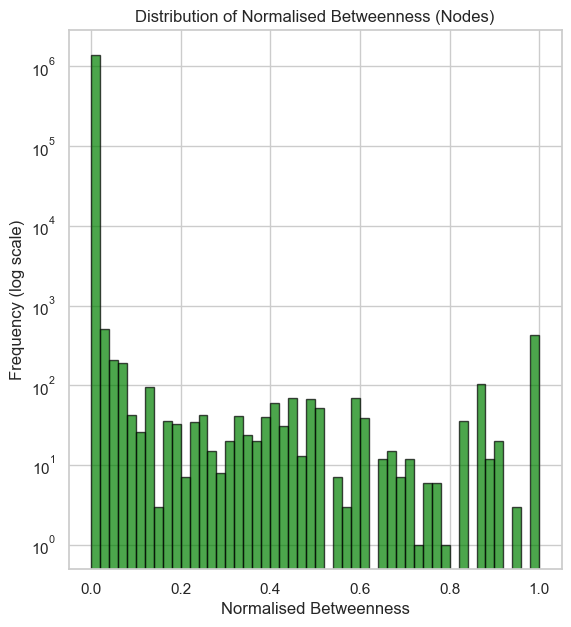

In [43]:
# plot log norm betw (nodes)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(node_normalized_betweenness.values(), bins=50, color='green', edgecolor='black', alpha=0.7, log=True)
plt.title('Distribution of Normalised Betweenness (Nodes)')
plt.xlabel('Normalised Betweenness')
plt.ylabel('Frequency (log scale)')

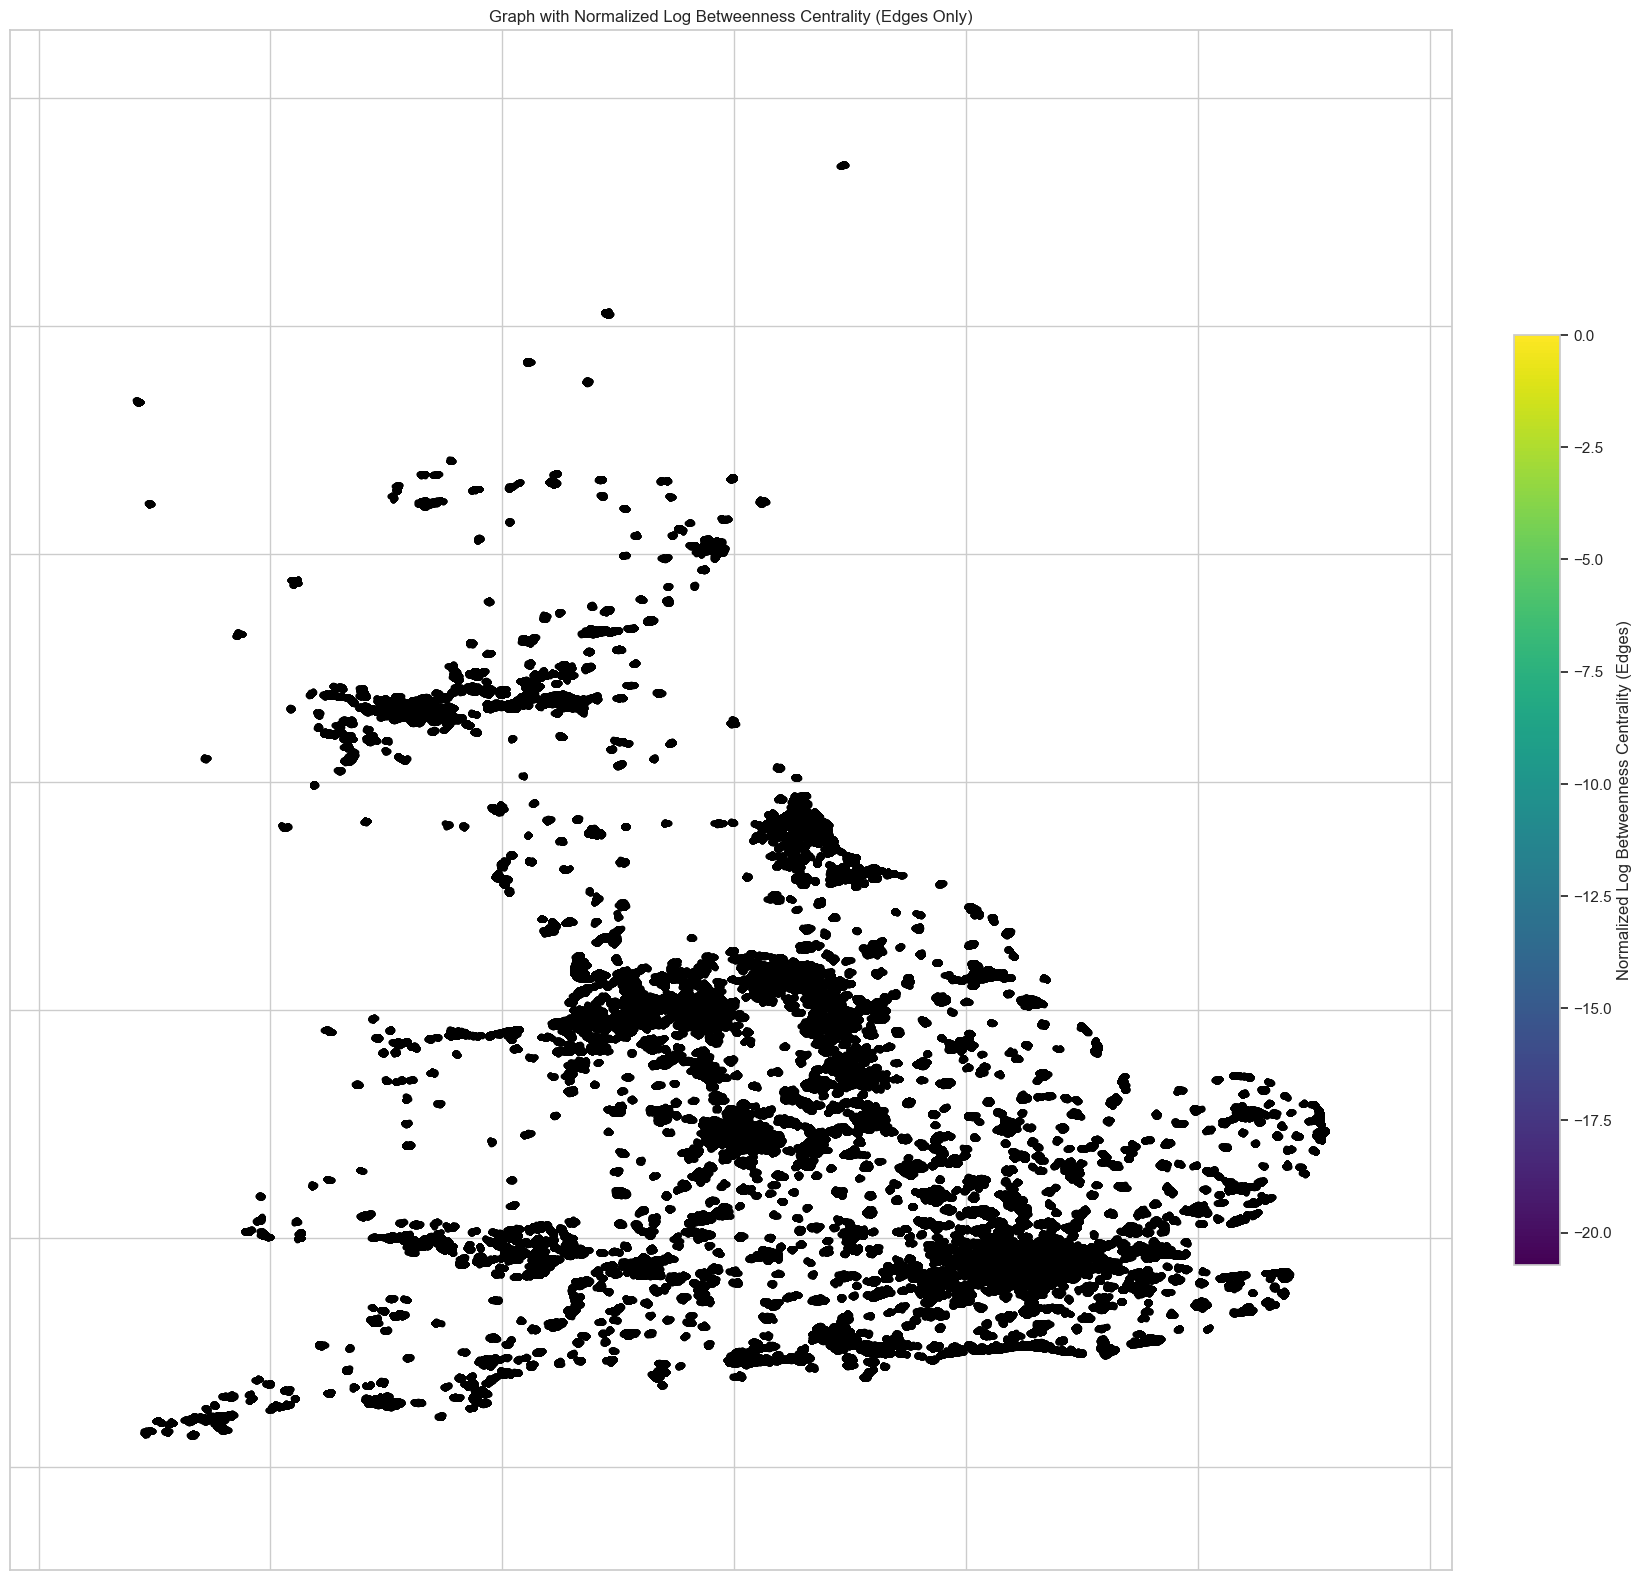

In [49]:
# Extract normalized betweenness values for edges
edge_betweenness = nx.get_edge_attributes(G_betw2, 'normalized_betweenness')

# Ensure betweenness values are log-normalized
edge_betweenness_log = {k: np.log(v + 1e-9) for k, v in edge_betweenness.items()}  # Adding small value to avoid log(0)

# Normalize betweenness values for coloring
norm_edge = mcolors.Normalize(vmin=min(edge_betweenness_log.values()), vmax=max(edge_betweenness_log.values()))

# Create colormap
cmap = plt.cm.viridis

# Extract node positions
pos = {node: (float(data['pos'].split(',')[0][1:]), float(data['pos'].split(',')[1][:-1])) for node, data in G_betw2.nodes(data=True)}

# Extract edge colors based on log-normalized betweenness
edge_colors = [cmap(norm_edge(edge_betweenness_log[(u, v)])) for u, v in G_betw2.edges()]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))

# Draw edges
nx.draw_networkx_edges(G_betw2, pos, edge_color=edge_colors, alpha=0.7, width=2, ax=ax)

# Draw nodes
nx.draw_networkx_nodes(G_betw2, pos, node_size=10, node_color='black', ax=ax)

# Add colorbar
sm_edge = plt.cm.ScalarMappable(norm=norm_edge, cmap=cmap)
sm_edge.set_array([])
cbar_edge = plt.colorbar(sm_edge, ax=ax, fraction=0.03, pad=0.04)
cbar_edge.set_label('Normalized Log Betweenness Centrality (Edges)')

plt.title('Graph with Normalized Log Betweenness Centrality (Edges Only)')
plt.show()

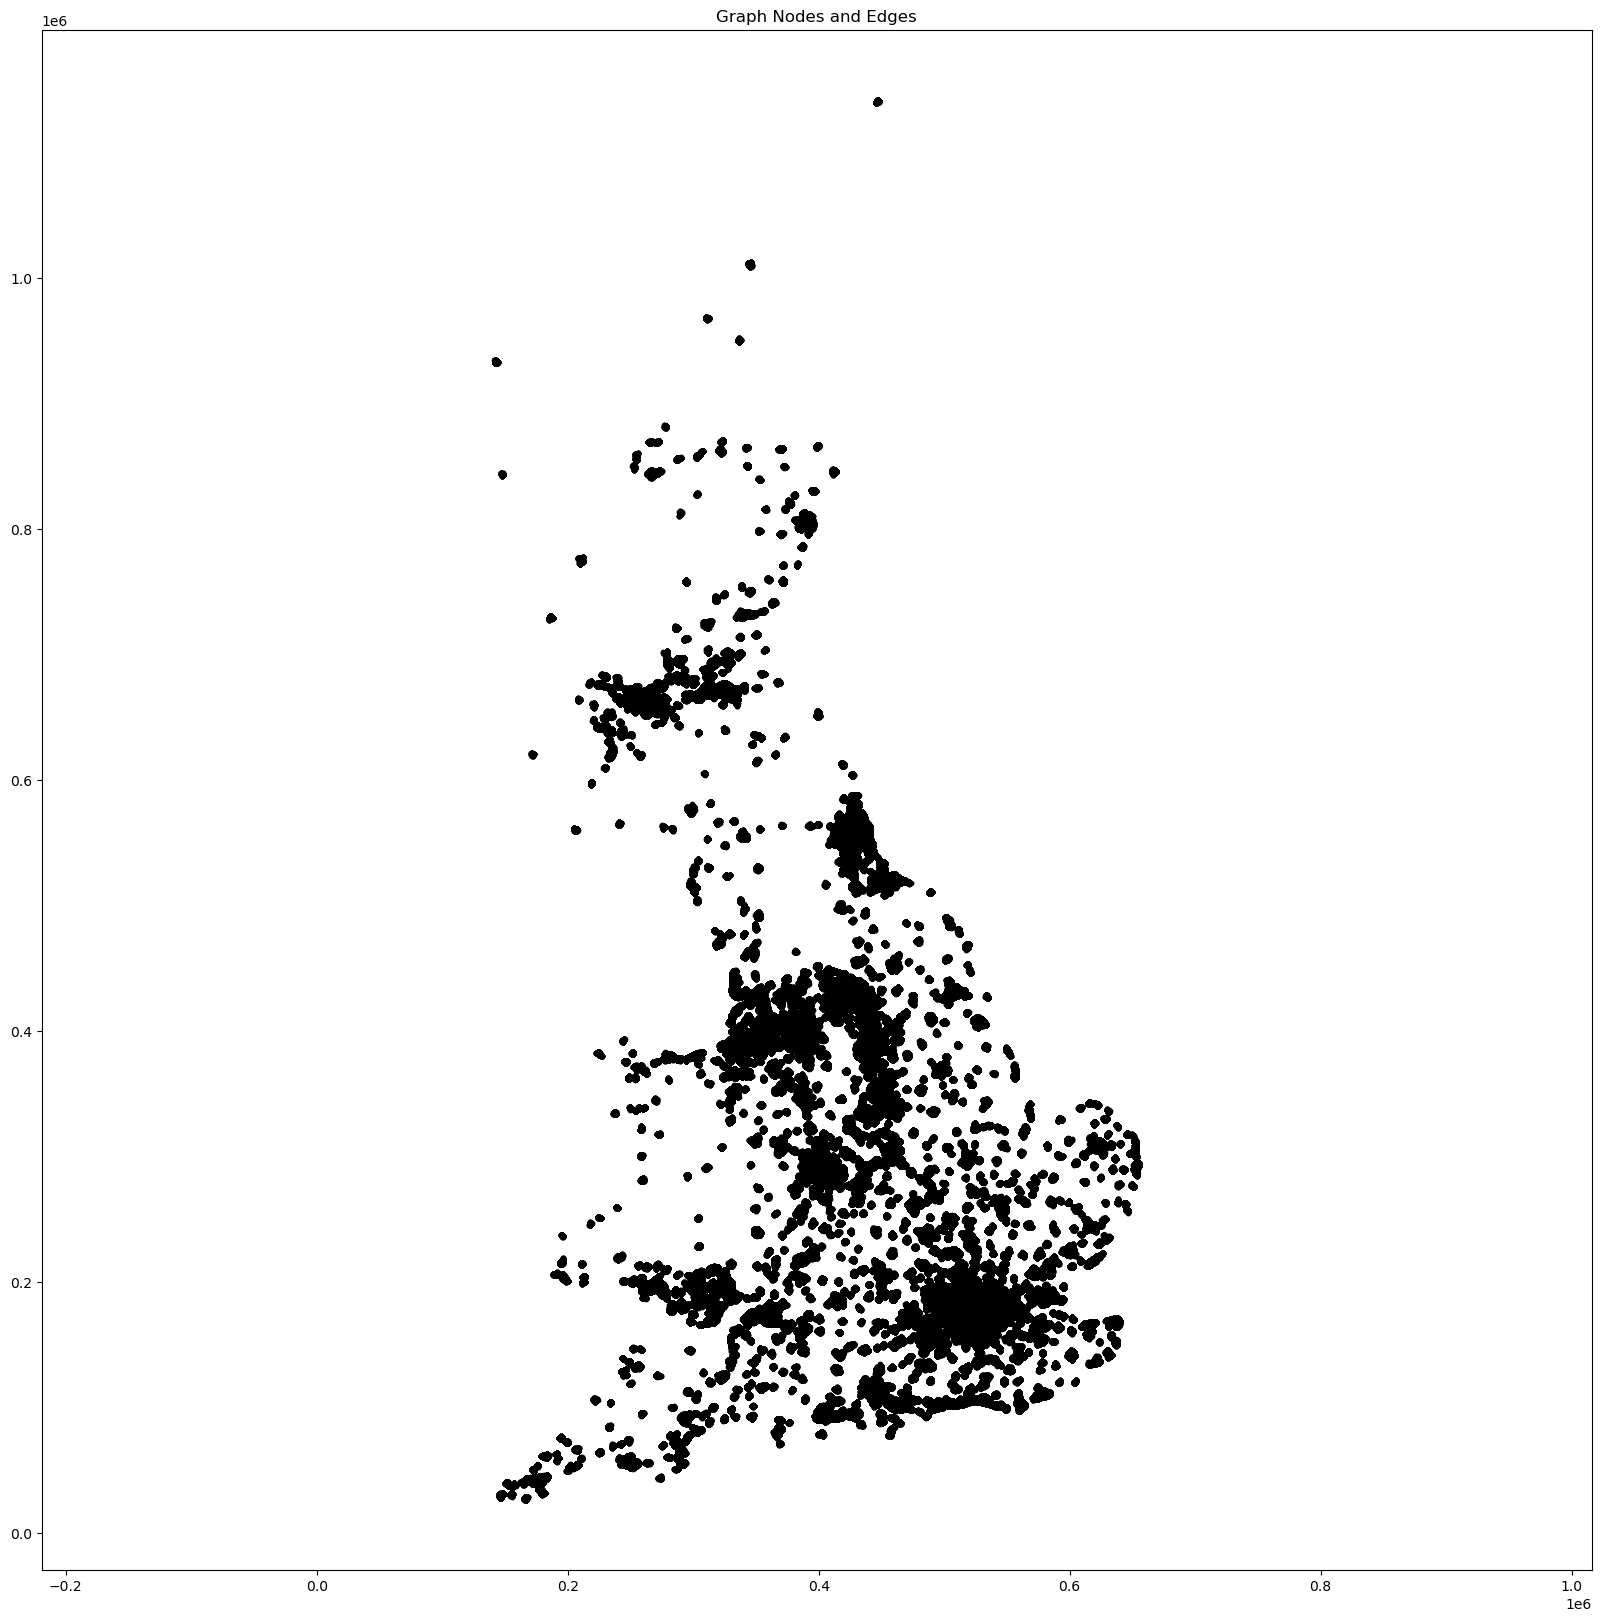

In [5]:
# get node positions
pos = {node: (float(data['pos'].split(',')[0][1:]), float(data['pos'].split(',')[1][:-1])) for node, data in G_betw2.nodes(data=True)}

# & for edges
edge_geometries = []
for u, v, data in G_betw2.edges(data=True):
    if 'geometry' in data:
        line = wkt.loads(data['geometry'])
        edge_geometries.append(line)

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))

# edges
for line in edge_geometries:
    x, y = line.xy
    ax.plot(x, y, color='gray', alpha=0.7, linewidth=1)

# nodes
x_nodes, y_nodes = zip(*pos.values())
ax.scatter(x_nodes, y_nodes, color='black', s=10, zorder=5)

ax.set_aspect('equal', 'datalim')
plt.title('Graph Nodes and Edges')
plt.show()